# Identify potential presynaptic proteins transcripts in aggregated *Lymnaea* protein-coding transcripts

**`Pfam_broad_Presynapse_IDs.txt`** ---> 100 Pfam IDs  **`NCBI_narrow_Presynapse_Sequences.fasta`** ---> 89 NCBI Sequences

## Preparation & HMM model searching

In [7]:
%%bash
## Shell

## Change working directory & Creating a new directory
cd Project/Battlefield/Explicit

## Pfam analysis of aggregated LS protein-coding transcripts
hmmsearch --cut_ga --tblout LS_all_CDHIT_Pfam_cutga.txt Pfam-A.hmm LS_all_CDHIT.fasta

## Using a broad Pfam IDs list to search for presynaptic-associated proteins

In [3]:
%%bash
## Shell

## Extract sequences that contain >=1 channel domains ---> 2322 sequence (not all unique)
grep -f Pfam_broad_Presynapse_IDs.txt LS_all_CDHIT_Pfam_cutga.txt > LS_broad_CDHIT_Pfam_Presynapse_hits.txt

## Extract IDs from the cutga file ---> 2322 sequence IDs (not all unique)
sed 's/\s.*$//g' LS_broad_CDHIT_Pfam_Presynapse_hits.txt > LS_broad_CDHIT_Pfam_Presynapse_hits_IDs.txt

## Extract unique sequence IDs ---> 1708 unique sequence IDs 
sort LS_broad_CDHIT_Pfam_Presynapse_hits_IDs.txt | uniq >  LS_broad_CDHIT_Pfam_Presynapse_unique_hits_IDs.txt

## Extract sequences for further analysis ---> 1708 sequences
faSomeRecords LS_all_CDHIT.fasta LS_broad_CDHIT_Pfam_Presynapse_unique_hits_IDs.txt LS_broad_Presynapse.fasta

grep: Pfam_broad_Presynapse_IDs.txt: No such file or directory
grep: Pfam_narrow_Presynapse_IDs.txt: No such file or directory


## Using a narrow NCBI sequences file to search for presynaptic proteins

In [9]:
%%bash
## Shell

## Find BLAST hits from the manually gathered fasta file
blastp                                                  \
-query           NCBI_narrow_Presynapse_Sequences.fasta \
-subject         LS_all_CDHIT.fasta                     \
-out             LS_Presynapse_HS_BLASTP.txt            \
-evalue          1E-10                                  \
-outfmt          6                                      \
-max_hsps        1                                      \
-max_target_seqs 100

In [10]:
%%bash
## Shell

## Extract IDs & Pairs from the BLAST result
awk '{print $2}' LS_Presynapse_HS_BLASTP.txt | sort | uniq > LS_narrow_NCBI_HS_hits_IDs.txt
awk '{print $2,$1}' LS_Presynapse_HS_BLASTP.txt | sort | uniq > LS_narrow_NCBI_HS_hits_pairs.txt

## Extract sequences for further analysis ---> 189 sequences
faSomeRecords LS_all_CDHIT.fasta LS_narrow_NCBI_HS_hits_IDs.txt LS_narrow_Presynapse.fasta

## Confirmation

In [11]:
## Confirm above analyses in Linux
import pandas as pd
import os
os.chdir("/home/paradoxist/Project/Battlefield/Explicit")

pfam = pd.read_csv("LS_all_CDHIT_Pfam_cutga.txt", delim_whitespace=True, skipfooter=10, header=1, engine='python')
pfam_final = pfam.drop(0)
print(pfam_final.shape)

pfam_final[["accession", "accession_extra"]] = pfam_final["accession"].str.split('.',expand=True) 

pfam_IDs = pd.read_csv("Pfam_all_Presynapse_IDs.txt", header=None)
IDs_list = pfam_IDs[0].tolist()

Presynapse_transcripts = pfam_final[pfam_final['accession'].isin(IDs_list)]
print(Presynapse_transcripts.shape)
print(Presynapse_transcripts["#"].nunique())

(31711, 24)
(2322, 25)
1708


## Sequence length distribution

Magnify[-Graphics-]
fig.1-length distribution.jpg
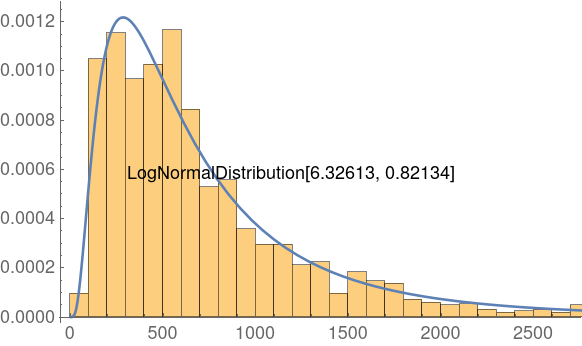

In [7]:
(*The Wolfram Language -- Please use the free Wolfram Engine for developers on the official website*)

(*Estimate & Visualize the sequence length distribution*)
data = StringLength@Import@"~/Project/Battlefield/Explicit/LS_all_CDHIT_Pfam_Presynapse_unique_hits.fasta";
dist = EstimatedDistribution[data,LogNormalDistribution[miu,sigma]];

Show[
Histogram[data,Automatic,"PDF"],
Plot[PDF[dist,l],{l,0,3000}],
Epilog->Inset@dist
]//Magnify

Export["fig.1-length distribution.jpg",%]

# Annotate IDs of the predicted presynapse transcripts to include Nr hit 

- Concatenated FASTA ID and Nr hit description are in **`LS_predicted_CNS_Presynapse_Nr_records.txt`**, which is taken from **`LS_all_CDHIT_nr.txt`**
- Check the result with the wolfram engine

## Labels extraction

In [12]:
%%bash
## Shell

## Change working directory
cd Project/Battlefield/Explicit

## Extract by rows that contain the predicted records
grep -f LS_all_CDHIT_Pfam_Presynapse_unique_hits_IDs.txt LS_all_CDHIT_Nr.txt > LS_predicted_CNS_Presynapse_Nr_records.txt

## Extract by columns that contain the hits discription
cut -f 1,4 LS_predicted_CNS_Presynapse_Nr_records.txt --output-delimiter='_' > LS_predicted_CNS_Presynapse_Nr_hits.txt
sed 's/ /_/g' LS_predicted_CNS_Presynapse_Nr_hits.txt > LS_predicted_CNS_Presynapse_Nr_hits.txt

In [3]:
%%bash
cut -f 1,4 LS_all_CDHIT_Nr.txt | sed 's/ /_/g' | sed 's/\t/_/g' > LS_simplified_Nr_hits.txt

## Explore the annotation results

Magnify[-Graphics-]
fig.2 protein word cloud.jpg
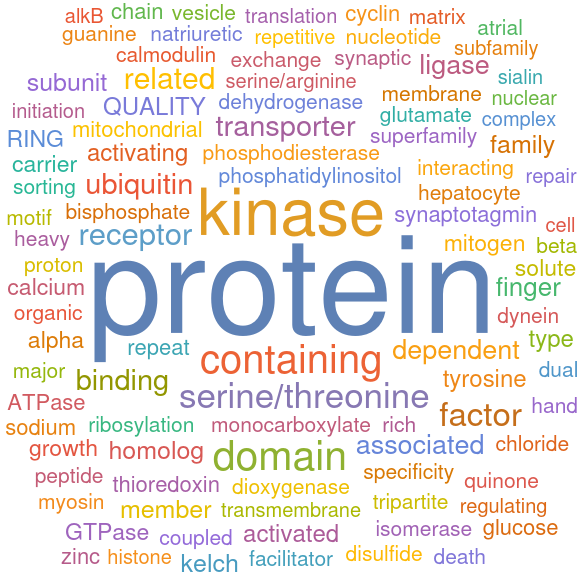

In [17]:
(*Have a basic textual inspection toward these matched proteins*)

pic=
WordCloud[
StringReplace[StringJoin@StringCases[set, "PREDICTED:"~~w__~~"-like" -> w], "-" -> " "],
WordSelectionFunction -> (StringLength@#>3 && StringContainsQ[#,LetterCharacter]&)
]//Magnify
Export["fig.2 protein word cloud.jpg",pic]

## Add annotations to sequences respectively

Magnify[-Graphics-]
LS_annotated_CNS_Presynapse.fasta
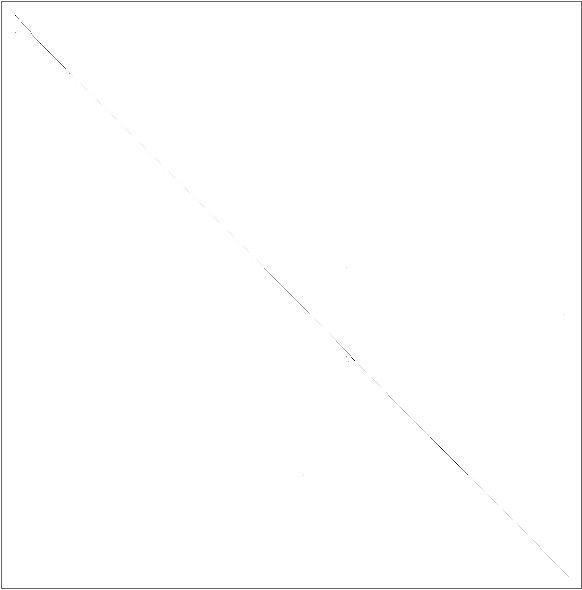

In [38]:
(*Import & Process & Visualize & Export*)

seq = Import["LS_all_CDHIT_Pfam_Presynapse_unique_hits.fasta","Data"];
ids = Import["LS_all_CDHIT_Pfam_Presynapse_unique_hits.fasta","Header"];
ref = Import["LS_predicted_CNS_Presynapse_Nr_hits.txt","Lines"];

Do[
If[StringContainsQ[ref[[i]],ids[[j]]],ids[[j]]=ref[[i]],Null],
{i,Length@ref},{j,Length@ids}
]
seq[[1]] = StringReplace[ids," "->"_"];

Export["LS_annotated_CNS_Presynapse.fasta",seq]

In [5]:
(*Import & Process & Visualize & Export*)

seq = Import["LS_narrow_Presynapse.fasta","Data"];
ids = Import["LS_narrow_Presynapse.fasta","Header"];
ref = Import["LS_simplified_Nr_hits.txt","Lines"];

Do[
If[StringContainsQ[ref[[i]],ids[[j]]],ids[[j]]=ref[[i]],Null],
{i,Length@ref},{j,Length@ids}
]
seq[[1]] = StringReplace[ids," "->"_"];

Export["LS_narrow_annotated_CNS_Presynapse.fasta",seq]

LS_narrow_annotated_CNS_Presynapse.fasta

# Internal comparison

## BLAST against itself to study proteins hierarchy

In [2]:
%%bash
## Shell
## Blast itself for community detection

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         LS_narrow_annotated_CNS_Presynapse.fasta \
-out             LS_Presynapse_LS_BLASTP.txt              \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 100

## Graph construction & components division & communities detection

Graph[<41>, <77>]
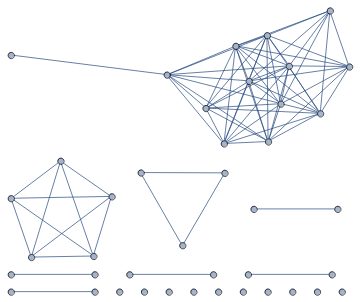

In [8]:
(*If protein A hits protein B, then there is a edge between A and B*)
(*Carry community detection and visualize the graph directly*)

NetData=SemanticImport@"LS_Presynapse_LS_BLASTP.txt";
SequenceSimilarityNetwork = SimpleGraph@Normal[NetData[All,1;;2]/.{i_,j_}->UndirectedEdge[i,j]]

## Component-level visualization

Magnify[-Graphics-]
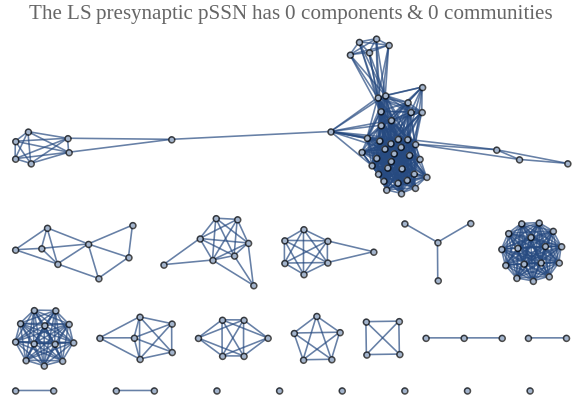

In [8]:
GraphPlot[
SequenceSimilarityNetwork,
PlotLabel->"The LS presynaptic pSSN has "<>ToString@Length@Components<>" components & "<>ToString@Length@Communities<>" communities",
LabelStyle->Directive[FontFamily->"TimesNewRoman"]
]//Magnify

## Community-level visualization

Magnify[-Graphics-   -Graphics-   -Graphics-   -Graphics-]

        -Graphics-   -Graphics-   -Graphics-   -Graphics-

        -Graphics-   -Graphics-   -Graphics-   -Graphics-

        -Graphics-   -Graphics-   -Graphics-   -Graphics-
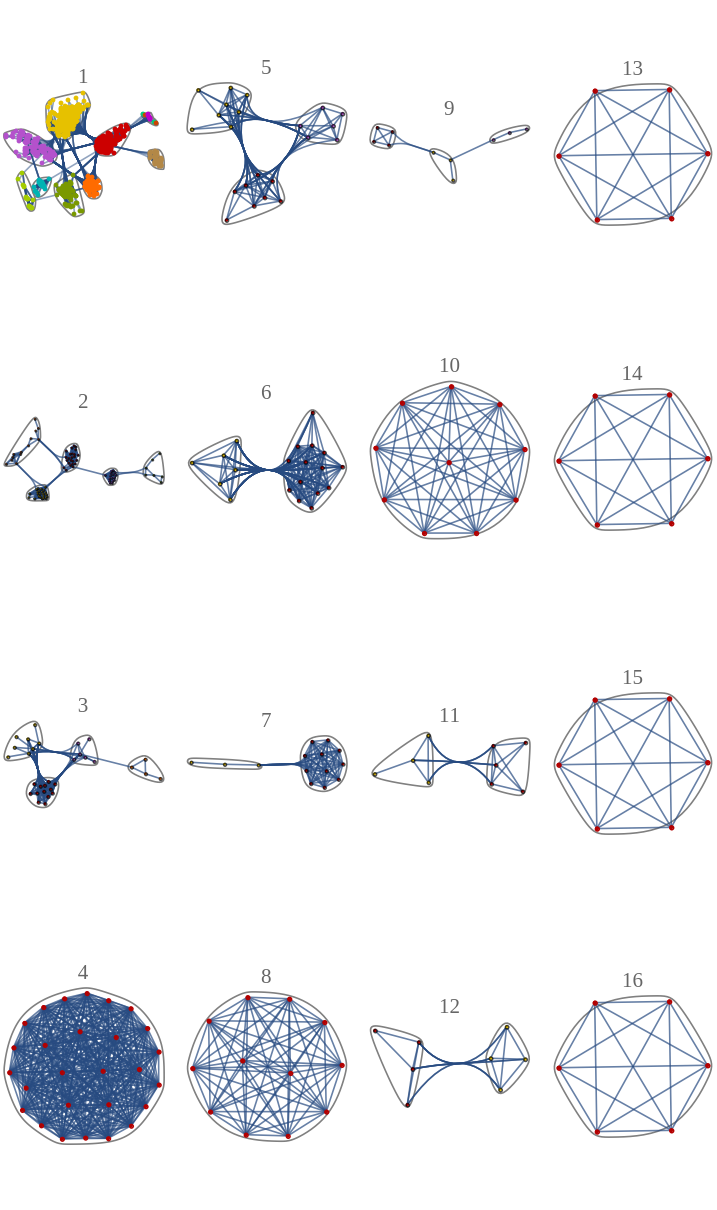

In [12]:
Multicolumn[
Table[
CommunityGraphPlot[
ComponentsGraph[[p]],
PlotLabel->p,
LabelStyle->Directive[FontFamily->"TimesNewRoman"]
],
{p,16}
],
4
]//Magnify
Export["fig.4-detected proteins communities of the largest components."<>#,%]&/@{"jpg","pdf","svg"};

## Basic inspection toward the largest component

Magnify[-Graphics-]
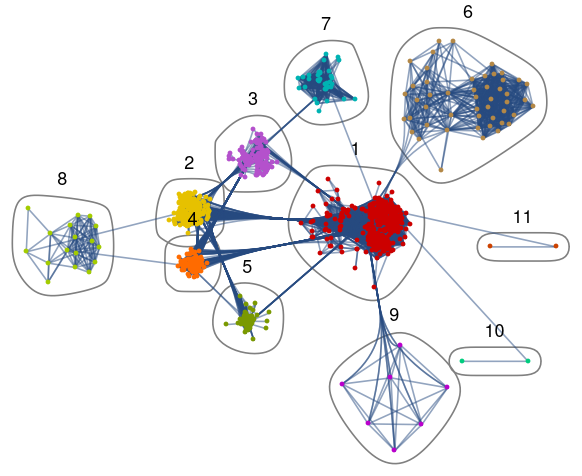

In [32]:
CommunityGraphPlot[
ComponentsGraph[[1]],
Method->"Hierarchical",
CommunityLabels->Range@12,
LabelStyle->Directive[FontFamily->"TimesNewRoman"]
]//Magnify

## Analysis of important components & communities

In [3]:
%%bash
ls | grep fasta

CE_non0_pep.fasta
DM_non0_pep.fasta
DR_non0_pep.fasta
LS_all_CDHIT.fasta
LS_all_CDHIT_Pfam_Presynapse_unique_hits.fasta
LS_annotated_CNS_Presynapse.fasta
MM_non0_pep.fasta
t.fasta
XT_non0_pep.fasta


In [11]:
%%bash
sed -n '3'p LS_detected_CNS_Presynapse_communities.tsv | sed "s/\"//g" | sed "s/\t/\n/g" > test.txt

In [12]:
%%bash
faSomeRecords LS_annotated_CNS_Presynapse.fasta test.txt t.fasta

In [ ]:
%%bash
clustalx

# External comparison

In [2]:
## Import libraries
import pandas as pd

## COG database

In [ ]:
%%bash
## Shell
## Blast itself for community detection

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         prot2003-2014.fa                  \
-out             LS_Presynapse_COGdb_BLASTP.txt    \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 108

## *Drosophila*

In [1]:
%%bash
## Shell

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         DM_non0_pep.fasta                 \
-out             LS_Presynapse_DM_BLASTP.txt       \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 1

In [2]:
%%bash
## Shell

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         DM_non0_pep.fasta                        \
-out             LS_narrow_Presynapse_DM_BLASTP.txt       \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 1

In [5]:
DM_blastp_Presynapse = pd.read_csv("LS_Presynapse_DM_BLASTP.txt", sep="\t", header=None)
DM_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
DM = DM_blastp_Presynapse[["qseqid", "bitscore"]]
DM.columns = ["ID", "DM"]

In [18]:
DMn_blastp_Presynapse = pd.read_csv("LS_narrow_Presynapse_DM_BLASTP.txt", sep="\t", header=None)
DMn_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
DMn = DMn_blastp_Presynapse[["qseqid", "bitscore"]]
DMn.columns = ["ID", "DM"]

In [7]:
print(DM.shape)
print(DM.head(10))
print(DMn.shape)
print(DMn.head(10))

(1540, 2)
                                                  ID     DM
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  389.0
1  evgLocus_FPS_855_XP_005094049.1_PREDICTED:_pro...  180.0
2  evgLocus_FPS_1362_XP_013095821.1_PREDICTED:_EF...  188.0
3  evgLocus_FPS_2218_XP_013095706.1_PREDICTED:_sy...  246.0
4  evgLocus_FPS_3715_XP_005111860.1_PREDICTED:_pe...  170.0
5  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  162.0
6  evgLocus_FPS_8367_XP_012946260.1_PREDICTED:_AD...  300.0
7  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  363.0
8  evgLocus_FPS_107_XP_013077005.1_PREDICTED:_met...   72.8
9  evgLocus_FPS_117_XP_013091593.1_PREDICTED:_ADP...  350.0
(189, 2)
                                                  ID     DM
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  389.0
1  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  162.0
2  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  363.0
3  evgLocus_FPS_159_AAY89300.1_guanine_nucleotide...  360.0
4  evgLocus_FPS_805_X

## Zebrafish

In [ ]:
%%bash
## Shell

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         DR_non0_pep.fasta                 \
-out             LS_Presynapse_DR_BLASTP.txt       \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 1

In [1]:
%%bash
## Shell

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         DR_non0_pep.fasta                        \
-out             LS_narrow_Presynapse_DR_BLASTP.txt       \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 1

In [3]:
DR_blastp_Presynapse = pd.read_csv("LS_Presynapse_DR_BLASTP.txt", sep="\t", header=None)
DR_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

DR  = DR_blastp_Presynapse[["qseqid", "bitscore"]]
DR.columns = ["ID", "DR"]

In [4]:
DRn_blastp_Presynapse = pd.read_csv("LS_narrow_Presynapse_DR_BLASTP.txt", sep="\t", header=None)
DRn_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

DRn = DRn_blastp_Presynapse[["qseqid", "bitscore"]]
DRn.columns = ["ID", "DR"]

In [5]:
print(DR.shape)
print(DR.head(10))
print(DRn.shape)
print(DRn.head(10))

(1627, 2)
                                                  ID     DR
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  393.0
1  evgLocus_FPS_855_XP_005094049.1_PREDICTED:_pro...  179.0
2  evgLocus_FPS_1362_XP_013095821.1_PREDICTED:_EF...  221.0
3  evgLocus_FPS_2218_XP_013095706.1_PREDICTED:_sy...  232.0
4  evgLocus_FPS_3715_XP_005111860.1_PREDICTED:_pe...  183.0
5  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  158.0
6  evgLocus_FPS_8367_XP_012946260.1_PREDICTED:_AD...  320.0
7  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  362.0
8  evgLocus_FPS_107_XP_013077005.1_PREDICTED:_met...   53.9
9  evgLocus_FPS_117_XP_013091593.1_PREDICTED:_ADP...  344.0
(189, 2)
                                                  ID     DR
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  393.0
1  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  158.0
2  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  362.0
3  evgLocus_FPS_159_AAY89300.1_guanine_nucleotide...  365.0
4  evgLocus_FPS_805_X

## Mouse

In [ ]:
%%bash
## Shell

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         MM_non0_pep.fasta                 \
-out             LS_Presynapse_MM_BLASTP.txt       \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 1

In [6]:
%%bash
## Shell

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         MM_non0_pep.fasta                        \
-out             LS_narrow_Presynapse_MM_BLASTP.txt       \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 1

In [7]:
MM_blastp_Presynapse = pd.read_csv("LS_Presynapse_MM_BLASTP.txt", sep="\t", header=None)
MM_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

MM = MM_blastp_Presynapse[["qseqid", "bitscore"]]
MM.columns = ["ID", "MM"]

In [8]:
MMn_blastp_Presynapse = pd.read_csv("LS_narrow_Presynapse_MM_BLASTP.txt", sep="\t", header=None)
MMn_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

MMn = MMn_blastp_Presynapse[["qseqid", "bitscore"]]
MMn.columns = ["ID", "MM"]

In [9]:
print(MM.shape)
print(MM.head(10))
print(MMn.shape)
print(MMn.head(10))

(1612, 2)
                                                  ID     MM
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  394.0
1  evgLocus_FPS_855_XP_005094049.1_PREDICTED:_pro...   73.6
2  evgLocus_FPS_1362_XP_013095821.1_PREDICTED:_EF...  240.0
3  evgLocus_FPS_2218_XP_013095706.1_PREDICTED:_sy...  229.0
4  evgLocus_FPS_3715_XP_005111860.1_PREDICTED:_pe...  180.0
5  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  157.0
6  evgLocus_FPS_8367_XP_012946260.1_PREDICTED:_AD...  312.0
7  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  360.0
8  evgLocus_FPS_107_XP_013077005.1_PREDICTED:_met...   53.9
9  evgLocus_FPS_117_XP_013091593.1_PREDICTED:_ADP...  346.0
(189, 2)
                                                  ID     MM
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  394.0
1  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  157.0
2  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  360.0
3  evgLocus_FPS_159_AAY89300.1_guanine_nucleotide...  360.0
4  evgLocus_FPS_805_X

## *Xenopus*

In [ ]:
%%bash
## Shell

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         XT_non0_pep.fasta                 \
-out             LS_Presynapse_XT_BLASTP.txt       \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 1

In [10]:
%%bash
## Shell

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         XT_non0_pep.fasta                        \
-out             LS_narrow_Presynapse_XT_BLASTP.txt       \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 1

In [11]:
XT_blastp_Presynapse = pd.read_csv("LS_Presynapse_XT_BLASTP.txt", sep="\t", header=None)
XT_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

XT = XT_blastp_Presynapse[["qseqid", "bitscore"]]
XT.columns = ["ID", "XT"]

In [12]:
XTn_blastp_Presynapse = pd.read_csv("LS_narrow_Presynapse_XT_BLASTP.txt", sep="\t", header=None)
XTn_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

XTn = XTn_blastp_Presynapse[["qseqid", "bitscore"]]
XTn.columns = ["ID", "XT"]

In [13]:
print(XT.shape)
print(XT.head(10))
print(XTn.shape)
print(XTn.head(10))

(1609, 2)
                                                  ID     XT
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  391.0
1  evgLocus_FPS_855_XP_005094049.1_PREDICTED:_pro...   74.3
2  evgLocus_FPS_1362_XP_013095821.1_PREDICTED:_EF...  241.0
3  evgLocus_FPS_2218_XP_013095706.1_PREDICTED:_sy...  221.0
4  evgLocus_FPS_3715_XP_005111860.1_PREDICTED:_pe...  188.0
5  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  161.0
6  evgLocus_FPS_8367_XP_012946260.1_PREDICTED:_AD...  320.0
7  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  360.0
8  evgLocus_FPS_107_XP_013077005.1_PREDICTED:_met...   60.5
9  evgLocus_FPS_117_XP_013091593.1_PREDICTED:_ADP...  346.0
(189, 2)
                                                  ID     XT
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  391.0
1  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  161.0
2  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  360.0
3  evgLocus_FPS_159_AAY89300.1_guanine_nucleotide...  358.0
4  evgLocus_FPS_805_X

## *C. elegans*

In [ ]:
%%bash
## Shell

blastp                                             \
-query           LS_annotated_CNS_Presynapse.fasta \
-subject         CE_non0_pep.fasta                 \
-out             LS_Presynapse_CE_BLASTP.txt       \
-evalue          1E-5                              \
-outfmt          6                                 \
-max_hsps        1                                 \
-max_target_seqs 1

In [14]:
%%bash
## Shell

blastp                                                    \
-query           LS_narrow_annotated_CNS_Presynapse.fasta \
-subject         CE_non0_pep.fasta                        \
-out             LS_narrow_Presynapse_CE_BLASTP.txt       \
-evalue          1E-5                                     \
-outfmt          6                                        \
-max_hsps        1                                        \
-max_target_seqs 1

In [15]:
CE_blastp_Presynapse = pd.read_csv("LS_Presynapse_CE_BLASTP.txt", sep="\t", header=None)
CE_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

CE = CE_blastp_Presynapse[["qseqid", "bitscore"]]
CE.columns = ["ID", "CE"]

In [16]:
CEn_blastp_Presynapse = pd.read_csv("LS_narrow_Presynapse_CE_BLASTP.txt", sep="\t", header=None)
CEn_blastp_Presynapse.columns = ["qseqid", "sseqid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]

CEn = CEn_blastp_Presynapse[["qseqid", "bitscore"]]
CEn.columns = ["ID", "CE"]

In [17]:
print(CE.shape)
print(CE.head(10))
print(CEn.shape)
print(CEn.head(10))

(1507, 2)
                                                  ID     CE
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  376.0
1  evgLocus_FPS_855_XP_005094049.1_PREDICTED:_pro...   77.0
2  evgLocus_FPS_1362_XP_013095821.1_PREDICTED:_EF...  155.0
3  evgLocus_FPS_2218_XP_013095706.1_PREDICTED:_sy...  219.0
4  evgLocus_FPS_3715_XP_005111860.1_PREDICTED:_pe...  152.0
5  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  161.0
6  evgLocus_FPS_8367_XP_012946260.1_PREDICTED:_AD...  316.0
7  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  346.0
8  evgLocus_FPS_107_XP_013077005.1_PREDICTED:_met...   65.9
9  evgLocus_FPS_117_XP_013091593.1_PREDICTED:_ADP...  347.0
(188, 2)
                                                  ID     CE
0  evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP...  376.0
1  evgLocus_FPS_7621_XP_009044447.1_hypothetical_...  161.0
2  evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ra...  346.0
3  evgLocus_FPS_159_AAY89300.1_guanine_nucleotide...  343.0
4  evgLocus_FPS_805_X

## Merge

In [19]:
data = None
list = [DMn, DRn, MMn, XTn, CEn]
for f in list:
    if data is None:
        data = f
    else:
        data = data.merge(f, on="ID")
        
data = data.set_index("ID")

In [20]:
print(data.shape)
print(data.head(10))

(188, 5)
                                                       DM     DR     MM  \
ID                                                                        
evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP-...  389.0  393.0  394.0   
evgLocus_FPS_7621_XP_009044447.1_hypothetical_p...  162.0  158.0  157.0   
evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ras...  363.0  362.0  360.0   
evgLocus_FPS_159_AAY89300.1_guanine_nucleotide-...  360.0  365.0  360.0   
evgLocus_FPS_805_XP_014670791.1_PREDICTED:_clat...  115.0  121.0  120.0   
evgLocus_FPS_1260_XP_013091283.1_PREDICTED:_ras...  389.0  394.0  392.0   
evgLocus_FPS_1448_XP_005093121.1_PREDICTED:_ADP...  347.0  357.0  357.0   
evgLocus_FPS_3072_Q05974.1_RecName:_Full=Ras-re...  370.0  372.0  375.0   
evgLocus_FPS_4641_XP_013078011.1_PREDICTED:_ras...  304.0  328.0  330.0   
evgLocus_FPS_5721_NP_001298203.1_ras-related_C3...  358.0  359.0  364.0   

                                                       XT     CE  
ID                     

In [21]:
import numpy as np
matrix = data.values
print(matrix.mean())
print(matrix.std())
print(matrix.shape)

394.11095744680847
398.2285676100918
(188, 5)


In [22]:
## Standardize bitscores
data_standardized = (data-matrix.mean())/matrix.std()
print(data_standardized.shape)
print(data_standardized.head(10))
data_standardized.to_csv("Presynapse_narrow_comparison_final.txt", sep="\t")

(188, 5)
                                                          DM        DR  \
ID                                                                       
evgLocus_FPS_535_XP_005093963.1_PREDICTED:_GTP-... -0.012834 -0.002790   
evgLocus_FPS_7621_XP_009044447.1_hypothetical_p... -0.582859 -0.592903   
evgLocus_FPS_8892_XP_005097179.1_PREDICTED:_ras... -0.078123 -0.080634   
evgLocus_FPS_159_AAY89300.1_guanine_nucleotide-... -0.085657 -0.073101   
evgLocus_FPS_805_XP_014670791.1_PREDICTED:_clat... -0.700881 -0.685815   
evgLocus_FPS_1260_XP_013091283.1_PREDICTED:_ras... -0.012834 -0.000279   
evgLocus_FPS_1448_XP_005093121.1_PREDICTED:_ADP... -0.118301 -0.093190   
evgLocus_FPS_3072_Q05974.1_RecName:_Full=Ras-re... -0.060546 -0.055523   
evgLocus_FPS_4641_XP_013078011.1_PREDICTED:_ras... -0.226279 -0.166013   
evgLocus_FPS_5721_NP_001298203.1_ras-related_C3... -0.090679 -0.088168   

                                                          MM        XT  \
ID                          

## Category labeling & heat map generation

In [19]:
(*Defining categories*)
cat=SequenceCases[
Import["NCBI_narrow_Presynapse_Sequences.fasta","Accession"]/.
(Rule[#,List@#]&/@{"NP_075461.2","NP_006642.1","NP_002857.1","NP_003449.2","XP_011524858.1"}),
{{a_String},as__String}->{a,as}
];
 
ids = Import["LS_narrow_Presynapse.fasta","Header"];
ref = Import["LS_simplified_Nr_hits.txt","Lines"];

FormerRuleSet=
Flatten@Table[
If[StringContainsQ[ref[[i]],ids[[j]]],Rule[ref[[i]],ids[[j]]],Nothing],
{i,Length@ref},{j,Length@ids}
];
MiddleRuleSet=Import["LS_narrow_NCBI_HS_hits_pairs.txt","Data"]/.{x_,y_}->Rule[x,y]; 
LatterRuleSet=
Flatten[
Thread[
Rule[
#,
"Category: "<>
Part[
{"Dense Projection","AZ-Proximal Zone","SV-Occupied Space","AZ-Distal Zone","Peri-Active Zone"},
Sequence@@FirstPosition[cat,#]
]
]
]&/@
cat
];

In [27]:
(*Heat map txt file generation & reshaping*)

HMdata=Part[Import["Presynapse_narrow_comparison_final.txt","Data"],All,Join[{1},Range@6]];
HMdata[[All,2]]=HMdata[[All,2]]/.Dispatch[FormerRuleSet]/.Dispatch[MiddleRuleSet]/.Dispatch[LatterRuleSet];
HMdata=Insert[HMdata,{"","","Type: Invertebrate","Type: Vertebrate","Type: Vertebrate","Type: Vertebrate","Type: Invertebrate"},2];
HMdata[[1;;2,1;;2]]=Table["",2,2];
HMdata=HMdata/.s_String->"'"<>s<>"'"//Quiet;
HMdata[[All,2]]=StringRiffle[#,{"(",", ",")"}]&/@HMdata[[All,1;;2]];
HMdata[[2,All]]=StringRiffle[#,{"(",", ",")"}]&/@Transpose@HMdata[[1;;2,All]];
HMdata=HMdata[[2;;-1,2;;-1]];
Export["Presynapse_comparison_final_hm.tsv",HMdata]

Presynapse_comparison_final_hm.tsv

In [1]:
%%bash
sed 's/"//g' Presynapse_comparison_final_hm.txt > Presynapse_comparison_hm.txt

-Graphics-
fig.interspecies comparison of hits number.pdf
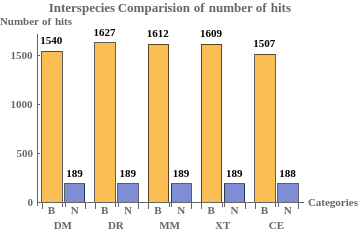

In [1]:
(*Number of hits comparison*)

BarChart[
Association@
Table[
i->Table[Length@Import["LS_"<>j<>"Presynapse_"<>i<>"_BLASTP.txt","Data"],{j,{"","narrow_"}}],
{i,{"DM","DR","MM","XT","CE"}}
],
LabelingFunction->Above,
ChartLabels->{{"DM","DR","MM","XT","CE"},{"B","N"}},
AxesLabel->{"Categories","Number of hits"},
PlotLabel->"Interspecies Comparision of number of hits",
LabelStyle->Directive[Bold,FontFamily->"TimesNewRoman"]
]
Export["fig.interspecies comparison of hits number.pdf",%]